In [1]:
import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Class_fxns import * #Fix this later
from bo_methods_lib.bo_methods_lib.analyze_data import * #Fix this later
from bo_methods_lib.bo_methods_lib.GPBO_Classes_plotters import * #Fix this later
import pympler
import pickle
import signac
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from textwrap import fill
import tensorflow_probability as tfp
import gpflow

from pympler import asizeof

from matplotlib import pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#Ignore inconcistent version warning
import warnings
# from sklearn.exceptions import InconsistentVersionWarning
# warnings.filterwarnings(action='ignore', category=InconsistentVersionWarning)

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-03-13 11:49:08.513286: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 11:49:08.513335: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 11:49:08.514991: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 11:49:08.525424: I tensorflow/core/platform/cpu_feature_guard

In [2]:
#Make Simulator and Training Data
cs_name_val = 1
noise_mean = 0
noise_std = None
seed = 1
#Define method, ep_enum classes, indecies to consider, and kernel
meth_name = Method_name_enum(3)
method = GPBO_Methods(meth_name)
gen_meth_theta = Gen_meth_enum(1)
gen_meth_x = Gen_meth_enum(2)
num_x_data = 5

#Define Simulator Class (Export your Simulator Object Here)
simulator = simulator_helper_test_fxns(cs_name_val, noise_mean, noise_std, seed)
num_theta_data = len(simulator.indeces_to_consider)*10
#Generate Exp Data (OR Add your own experimental data as a Data class object)
set_seed = 1 #Set set_seed to 1 for data generation
gen_meth_x = Gen_meth_enum(gen_meth_x)
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x, set_seed)
#Set simulator noise_std artifically as 5% of y_exp mean (So that noise will be set rather than trained)
simulator.noise_std = np.abs(np.mean(exp_data.y_vals))*0.05
print(simulator.noise_std)
#Note at present, training data is always the same between jobs since we set the data generation seed to 1
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x, 1.0, seed, False)
val_data = simulator.gen_sim_data(10, 10, Gen_meth_enum(1), Gen_meth_enum(1), 1.0, simulator.seed, False)
# print(sim_data.theta_vals)
all_gp_data = sim_data
all_val_data = val_data

0.09972314379508178


In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

retrain_GP = 5
normalize = True
noise_std = simulator.noise_std #Yexp_std is exactly the noise_std of the GP Kernel

#Get GP object
gp_object = Type_2_GP_Emulator(all_gp_data, all_val_data, None, None, None, Kernel_enum(1), None, noise_std, None, 
                                retrain_GP, seed, normalize, None, None, None, None)
#Train on all sets
train_data, test_data = gp_object.set_train_test_data(1.0, seed)
new_gp_model = gp_object.set_gp_model()
gp_object.train_gp()
gpflow.utilities.print_summary(gp_object.fit_gp_model)
hps_org = gp_object.trained_hyperparams
print(hps_org)

╒════════════════════════════════════╤═══════════╤══════════════════╤════════════╤═════════════╤═════════╤═════════╤══════════════════════════════╕
│ name                               │ class     │ transform        │ prior      │ trainable   │ shape   │ dtype   │ value                        │
╞════════════════════════════════════╪═══════════╪══════════════════╪════════════╪═════════════╪═════════╪═════════╪══════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │ HalfCauchy │ True        │ ()      │ float64 │ 292.5185                     │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼─────────┼──────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │            │ True        │ (3,)    │ float64 │ [45.12247 23.58421  1.67842] │
├────────────────────────────────────┼───────────┼──────────────────┼────────────┼─────────────┼─────────┼──────

In [4]:
#Create a Data Class which is Sim and Val Data together
t_train_val = np.concatenate((sim_data.theta_vals, val_data.theta_vals))
x_train_val = np.concatenate((sim_data.x_vals, val_data.x_vals))
y_train_val = np.concatenate((sim_data.y_vals, val_data.y_vals))

all_data = Data(t_train_val, x_train_val, y_train_val, None, None, None, None, None, 
all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)

X = gp_object.featurize_data(all_data)
y = all_data.y_vals

In [5]:
n_samples = len(all_data.y_vals)

predict_mean = []
predict_std = []
train_mean = []
train_std = []


#For each sample in the full set
for i in range(n_samples):
    #Get sample Data
    t_leave_one = np.atleast_2d(all_data.theta_vals[i])
    X_leave_one = np.atleast_2d(all_data.x_vals[i])
    y_leave_one = np.atleast_1d(all_data.y_vals[i])
    t_rest = np.delete(all_data.theta_vals,i,axis=0)
    X_rest = np.delete(all_data.x_vals,i,axis=0)
    y_rest = np.delete(all_data.y_vals,i,axis=0)
    loo_data = Data(t_leave_one, X_leave_one, y_leave_one, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    loo_data_train = Data(t_rest, X_rest, y_rest, None, None, None, None, None, 
                            all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    # t_rest = np.delete(all_data.theta_vals,i,axis=0)
    # X_rest = np.delete(all_data.x_vals,i,axis=0)
    # y_rest = np.delete(all_data.y_vals,i,axis=0)
    # loo_data_train = Data(t_rest, X_rest, y_rest, None, None, None, None, None, 
    #                         all_gp_data.bounds_theta, all_gp_data.bounds_x, 1.0, seed)
    
    #Create GP object based on the above
    gp_new = Type_2_GP_Emulator(loo_data_train, loo_data, None, loo_data_train, None, Kernel_enum(1), None, noise_std, None, 
                                1, seed, normalize, None, None, None, None)
    gp_new.scalerX = gp_object.scalerX
    gp_new.scalerY = gp_object.scalerY
    
    #Create GP Model Based On Past Hyperparamaters
    loo_ft = gp_new.featurize_data(loo_data)
    loo_ft_trn = gp_new.featurize_data(loo_data_train)
    looft_scl = gp_new.scalerX.transform(loo_ft_trn)
    scl_looy = gp_new.scalerY.transform(y_rest.reshape(-1,1))
    gp_new.train_data_init = loo_ft_trn
    # gp_new.scalerX.fit(loo_ft_trn)
    # gp_new.scalerY = gp_object.scalerY.fit(y_rest.reshape(-1,1))
    mat_kern = gpflow.kernels.Matern52(variance = hps_org[2], lengthscales=hps_org[0])
    noise_kern = gpflow.kernels.White(variance=hps_org[1])
    lik_noise_var = np.maximum(1.000001e-6, float(gp_object.fit_gp_model.likelihood.variance.numpy()))
    kernel = mat_kern + noise_kern
    new_gp_model = gpflow.models.GPR((looft_scl, scl_looy), kernel=kernel, noise_variance=lik_noise_var)
    for param in new_gp_model.trainable_parameters:
        gpflow.set_trainable(param, False)
    gp_new.fit_gp_model = new_gp_model
    gp_new.feature_train_data = loo_ft_trn

    #Predict With New model
    #Get data in vector form into array form
    if len(loo_ft.shape) < 2:
        loo_ft.reshape(1,-1)
    #scale eval_point if necessary
    if gp_new.normalize == True:
        eval_points = gp_new.scalerX.transform(loo_ft)
    else:
        eval_points = loo_ft
    
    #Evaluate GP given parameter set theta and state point value
    gp_mean_scl, gp_covar_scl = gp_new.fit_gp_model.predict_f(eval_points, full_cov=True)
    #Remove dimensions of 1
    gp_mean_scl = gp_mean_scl.numpy()
    # print(gp_covar_scl.shape)
    gp_covar_scl = np.squeeze(gp_covar_scl, axis = 0)

    #Unscale gp_mean and gp_covariance
    if gp_new.normalize == True:
        gp_mean = gp_new.scalerY.inverse_transform(gp_mean_scl.reshape(-1,1)).flatten()
        gp_covar = float(gp_new.scalerY.scale_**2) * gp_covar_scl  
    else:
        gp_mean = gp_mean_scl
        gp_covar = gp_covar_scl
    
    y_loo_mean = gp_mean
    y_loo_var = np.diag(gp_covar)
    y_loo_std =  np.sqrt(y_loo_var)

    #Check for feat_loo in train and test feat
    is_row_train = np.any(np.all(gp_object.feature_train_data == loo_ft, axis=1))
    if is_row_train:
        train_mean.append(float(y_loo_mean))
        train_std.append(float(y_loo_std))
    else:
        predict_mean.append(float(y_loo_mean))
        predict_std.append(float(y_loo_std))

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════════════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value                        │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════════════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ False       │ ()      │ float64 │ 292.5185                     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────────────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ False       │ (3,)    │ float64 │ [45.12247 23.58421  1.67842] │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────

In [6]:
R2_score = r2_score(val_data.y_vals, predict_mean)
print(predict_mean)
print(predict_std)
print(R2_score)

[6.362681548721473, -1.1906720204421757, -2.523616746589374, 0.7884300791103774, 12.202871619928715, 3.384642418800067, -6.815154895205204, -1.5362167967887774, -0.3013595410643027, 0.7116386893520732, 5.537577790236226, -1.992428737431075, -4.433505671010382, 0.8714657790993903, 10.373556203488361, 3.13452915355844, -10.775617305775858, -2.7356942194155836, -0.3194821485377426, 0.7748581807645004, 4.279967024996128, 1.1214812632634188, 1.3880963050897972, -0.05207870724793584, 9.893818170716097, 1.6378829910378043, -0.023750508365636518, 1.3629569100453436, 0.24414383754051122, -0.03599396986945553, 1.8875584178192455, -0.35567043045068725, -1.85878483158161, -0.030553559363598267, 5.42545291913994, 0.538611237733636, -7.151078941070576, -0.7341272663458926, 0.06356903862290506, -0.05084086535384015, -3.136107873721983, 0.04647965237432626, -2.209497096186977, -0.9310669366567281, -2.4894779491276093, -2.5305339160516263, -9.737259218127903, -0.6356749904459866, 0.36612513408621605, -

In [7]:
def kernel_info(kernel):
    outputscl_final = float(kernel.kernels[0].variance.numpy())
    lenscl_final = kernel.kernels[0].lengthscales.numpy()
    noise_final = float(kernel.kernels[1].variance.numpy())

    if isinstance(kernel.kernels[0], gpflow.kernels.RBF):
        kern_type = "RBF"
    elif isinstance(kernel.kernels[0], gpflow.kernels.Matern32):
        kern_type = "Mat32"
    elif isinstance(kernel.kernels[0], gpflow.kernels.Matern52):
        kern_type = "Mat52"
    else:
        print(type(kernel))

    if isinstance(lenscl_final, np.ndarray):
        lenscl_str = '[' + ', '.join('{:.2g}'.format(x) for x in lenscl_final) + ']'
    else:
        lenscl_str = f"{lenscl_final:.2g}"
    
    info_str = "tau=" +'{:.3g}'.format(outputscl_final) + ", "+ str(kern_type) +"="+ lenscl_str + ", noise="'{:.2g}'.format(noise_final)
    return info_str

print(kernel_info(gp_object.fit_gp_model.kernel))

tau=293, Mat52=[45, 24, 1.7], noise=0.0013


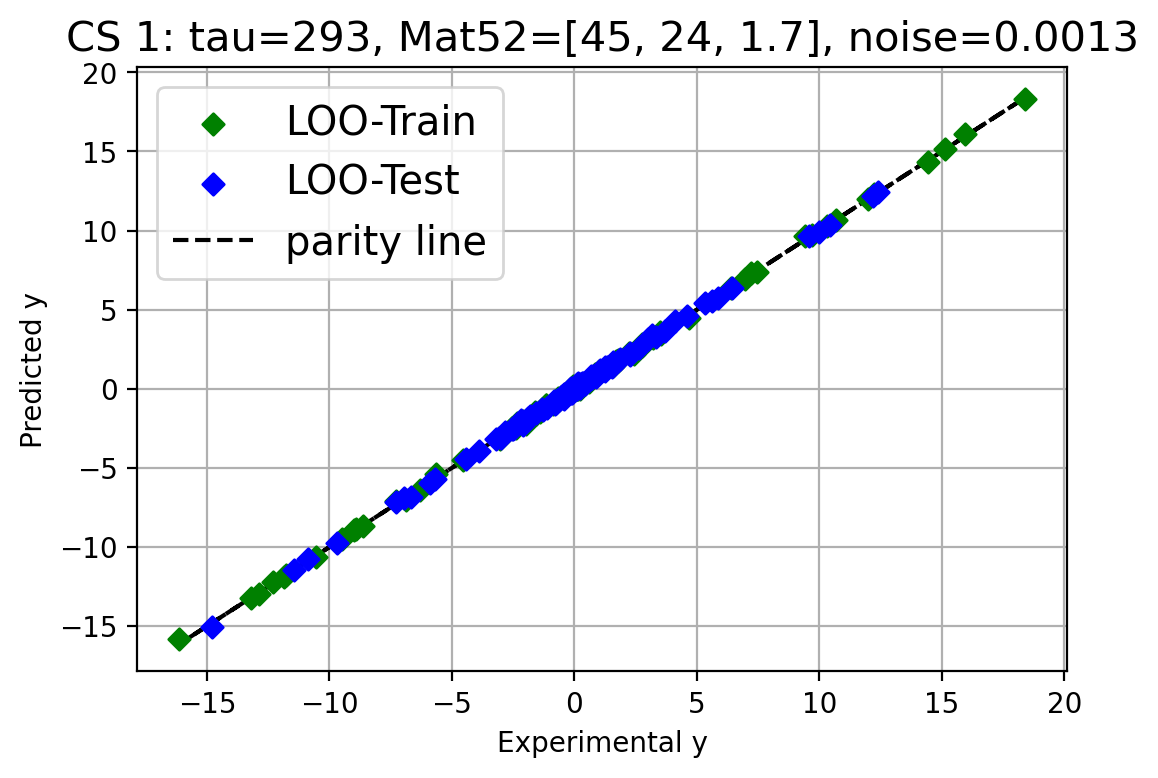

In [8]:
text = 'LOO-$R^2$ score: ' + str(np.round(R2_score,2))

plt.errorbar(sim_data.y_vals, train_mean, 1.96*np.array(train_std), c='g', fmt = ' ', alpha = 0.3, zorder =1)
plt.errorbar(val_data.y_vals, predict_mean, 1.96*np.array(predict_std), c='b', fmt = ' ', alpha = 0.3, zorder=2)
plt.scatter(sim_data.y_vals, train_mean, 30,c='g', marker='D', label='LOO-Train', zorder= 3)
plt.scatter(val_data.y_vals, predict_mean, 30,c='b', marker='D', label='LOO-Test', zorder = 4)

plt.plot(y,y,'k--', label='parity line')
plt.xlabel('Experimental y')
plt.ylabel('Predicted y')
plt.title(fill("CS " + str(cs_name_val) + ": " + kernel_info(gp_object.fit_gp_model.kernel), 60), fontdict={'size':15})
plt.grid(True)
plt.legend(fontsize='x-large')
# plt.text(1500, 100, text)
# plt.text(1000, 0, '*Error Bars are 1.96 Standard Deviation')
# plt.savefig('pic_Loo_R2_score')
plt.show()

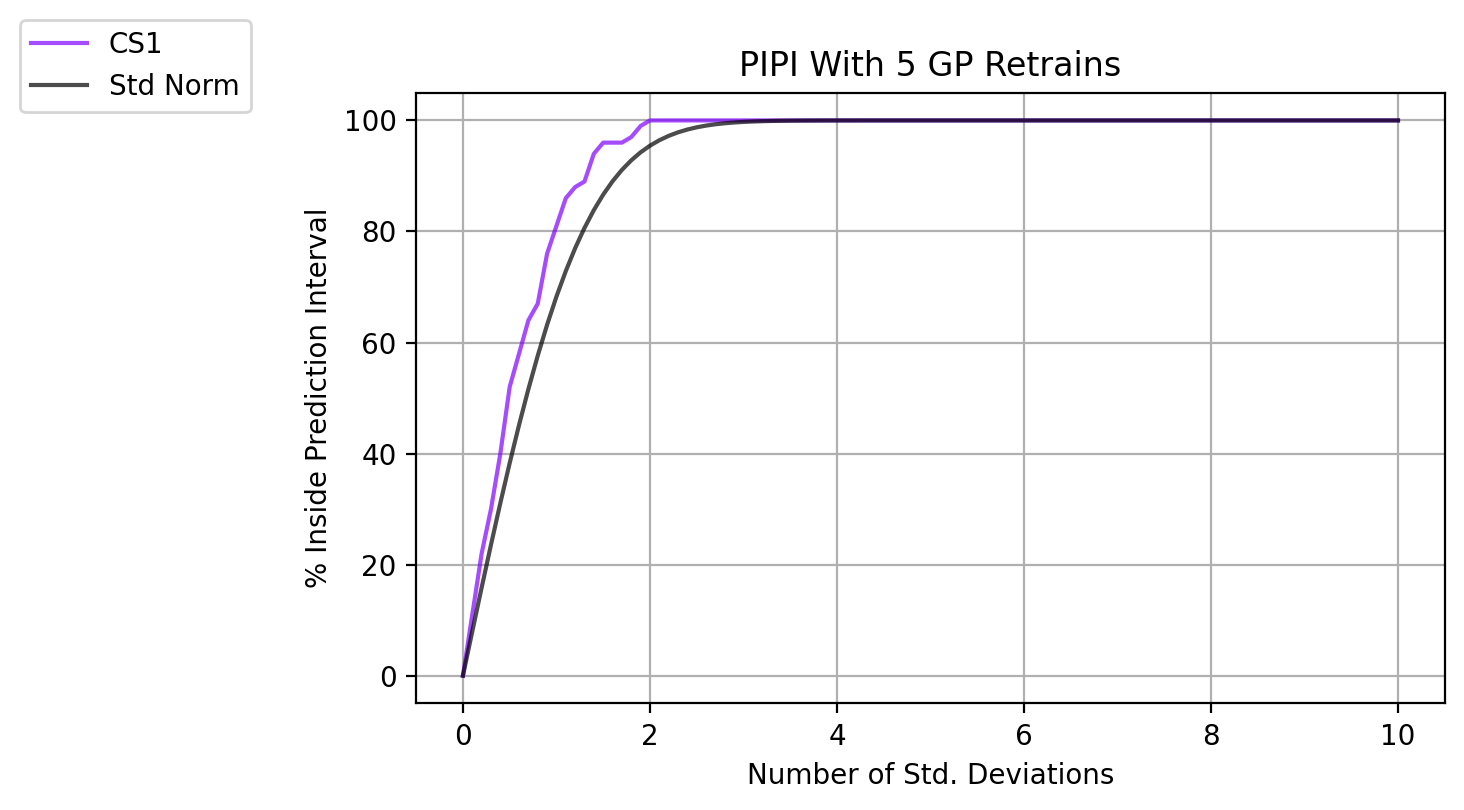

In [9]:
num_stds_ax = np.linspace(0,10,101)
norm_vals = (norm.cdf(num_stds_ax) - norm.cdf(-num_stds_ax))*100

fig = plt.figure()
cmap = plt.get_cmap('rainbow', 1)

misc_gp_mean = predict_mean
misc_var_return = np.array(predict_std)**2

#For Each Point, calculate the std multiplier that puts us in the prediction interval
#Calculate num_stds = (y-mu)/sigma
num_stds = sorted(abs((all_val_data.y_vals-misc_gp_mean)/np.sqrt(abs(misc_var_return))).tolist(), reverse = True)

#Calculate % in side prediction interval at each point
pct_ins = np.array([np.sum(num_stds < num_std) for num_std in num_stds_ax])/len(num_stds)*100
plt.plot(num_stds_ax, pct_ins, color = cmap(0), alpha=0.7, label = "CS" + str(cs_name_val))
    
plt.plot(num_stds_ax, norm_vals, color='black', alpha=0.7, label = "Std Norm")
fig.legend(loc= "upper right", bbox_to_anchor=(-0.02, 1), 
                       borderaxespad=0)
plt.xlabel('Number of Std. Deviations')
plt.ylabel('% Inside Prediction Interval')
plt.title('PIPI With ' + str(retrain_GP) + " GP Retrains")
plt.grid(True)
plt.tight_layout()
# plt.savefig("Results/PIPI_Retrain_"+str(retrain_GP) +".png",  bbox_inches='tight')
# plt.close()